In [1]:
import codecs
import os
import os.path
import shutil
import string
import sys
import warnings
from typing import Any, Callable, Dict, List, Optional, Tuple
from urllib.error import URLError
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
from PIL import Image
import json
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Normalize
import torchvision.transforms as transforms
#from .utils import download_and_extract_archive, extract_archive, verify_str_arg, check_integrity
from torchvision.datasets.vision import VisionDataset
import pandas as pd
import glob
import matplotlib.pyplot as plt

In [12]:
class BIWI(VisionDataset):


    training_file = "training.pt"
    test_file = "test.pt"


    @property
    def train_labels(self):
        warnings.warn("train_labels has been renamed targets")
        return self.targets

    @property
    def test_labels(self):
        warnings.warn("test_labels has been renamed targets")
        return self.targets

    @property
    def train_data(self):
        warnings.warn("train_data has been renamed data")
        return self.data

    @property
    def test_data(self):
        warnings.warn("test_data has been renamed data")
        return self.data

    def __init__(
        self,
        root: str = None,
        train: bool = True,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        split : float = 0.5
      
    ) -> None:
        super().__init__(root, transform=transform, target_transform=target_transform)
        self.train = train  # training set or test set
        self.split = split
        self.height=96
        self.width=96

        

        
	
        self.json_files = self._load_data()
 
        

        
    def _load_data(self,mypath = "dataset/sample/sample_set_annotated/"):
        onlyfiles_json = []
        
        for data in glob.glob(mypath+"*.json"):
            onlyfiles_json.append(data)
            
        # calculate the validation data sample length
        valid_split = int(len(onlyfiles_json) * self.split)
        # calculate the training data samples length
        train_split = int(len(onlyfiles_json) - valid_split)  
        
        if self.train == True:
            onlyfiles_json = onlyfiles_json[:train_split]
            print(f"Training sample instances: {len(onlyfiles_json)}")
        elif self.train == False:
            onlyfiles_json = onlyfiles_json[-valid_split:]
            print(f"Validation sample instances: {len(onlyfiles_json)}")
        
        return onlyfiles_json
       
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        
        data = json.load(open(self.json_files[index]))
        print(data)
        # print(data["shapes"][0]["points"][0])
        print(self.json_files[index].split('.')[0] + '.jpg')
        img_path = self.json_files[index].split('.')[0] + '.jpg'
        target = data["shapes"][0]["points"][0]
        


        img = Image.open(img_path)
        res_x, res_y = img.size
        img = img.resize((self.height,self.width), Image.BILINEAR)
        convert = ToTensor()
        img = convert(img)


        target = [target[0]/res_x, target[1]/res_y]
        


        target = torch.Tensor(target)
        

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

       
        return img, target



    def __len__(self) -> int:
        return len(self.json_files)
    
    @property
    def raw_folder(self) -> str:
        return os.path.join(self.root, self.__class__.__name__, "raw")

    @property
    def processed_folder(self) -> str:
        return os.path.join(self.root, self.__class__.__name__, "processed")

    @property
    def class_to_idx(self) -> Dict[str, int]:
        return {_class: i for i, _class in enumerate(self.classes)}

    def _check_exists(self) -> bool:
        return all(
            check_integrity(os.path.join(self.raw_folder, os.path.splitext(os.path.basename(url))[0]))
            for url, _ in self.resources
        )

    def download(self) -> None:
        """Download the MNIST data if it doesn't exist already."""

        if self._check_exists():
            return

        os.makedirs(self.raw_folder, exist_ok=True)

        # download files
        for filename, md5 in self.resources:
            for mirror in self.mirrors:
                url = f"{mirror}{filename}"
                try:
                    print(f"Downloading {url}")
                    download_and_extract_archive(url, download_root=self.raw_folder, filename=filename, md5=md5)
                except URLError as error:
                    print(f"Failed to download (trying next):\n{error}")
                    continue
                finally:
                    print()
                break
            else:
                raise RuntimeError(f"Error downloading {filename}")

    def extra_repr(self) -> str:
        split = "Train" if self.train is True else "Test"
        return f"Split: {split}"

    # get the training and validation data samples

In [13]:
print('\n-------------- PREPARING DATA --------------\n')
train_data=BIWI(train = True)
valid_data = BIWI(train = False)
print(train_data)


-------------- PREPARING DATA --------------

Training sample instances: 6
Validation sample instances: 6
Dataset BIWI
    Number of datapoints: 6
    Split: Train


In [14]:
print('\n-------------- DATA PREPRATION DONE --------------\n')
    # prepare data loaders
train_loader = DataLoader(train_data,
                              batch_size=256,
                              shuffle=False)
valid_loader = DataLoader(valid_data,
                              batch_size=256,
                              shuffle=False)


-------------- DATA PREPRATION DONE --------------



{'version': '0.3.3', 'flags': {}, 'shapes': [{'label': 'S40_40_G', 'text': '', 'points': [[248.0, 244.0], [316.0, 327.0]], 'group_id': None, 'shape_type': 'rectangle', 'flags': {}}, {'label': 'S40_40_B', 'text': '', 'points': [[99.0, 241.0], [162.0, 325.0]], 'group_id': None, 'shape_type': 'rectangle', 'flags': {}}], 'imagePath': 'rnD_robocup_009.jpg', 'imageData': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHgAoADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobH

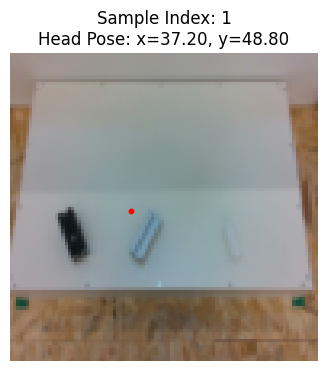

In [15]:
sample_indices = [1]

# Visualize the sample images and head pose data
for index in sample_indices:
    image, target = train_data[index]
    print(target.shape)
    # Convert the target back to original image coordinates
    res_x, res_y = image.shape[-1], image.shape[-2]
    target = [target[0] * res_x, target[1] * res_y]

    plt.figure(figsize=(8, 4))
    plt.imshow(image.permute(1, 2, 0))  # Convert tensor to image format (C, H, W) -> (H, W, C)
    plt.scatter(target[0], target[1], color='red', marker='o', s=10)
    plt.title(f"Sample Index: {index}\nHead Pose: x={target[0]:.2f}, y={target[1]:.2f}")
    plt.axis('off')
    plt.show()